In [35]:
!pip install seaborn

In [36]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from pathlib import Path
from tensorflow.keras.utils import load_img

# encode both columns label and variety
from sklearn.preprocessing import LabelEncoder
# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

In [37]:
#create data generators
train_datagen = ImageDataGenerator(rescale = 1./255, 
                             rotation_range=40,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [38]:
def count_images_in_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    image_count = 0
    for filename in os.listdir(folder_path):
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1
    return image_count

def count_images_in_all_folders(root_folder):
    for dirpath, _, _ in os.walk(root_folder):
        folder_name = os.path.basename(dirpath)
        image_count = count_images_in_folder(dirpath)
        print(f"Folder '{folder_name}': {image_count} images")

fruits = ['Apple', 'avocado', 'Banana', 'cherry', 'kiwi', 'mango', 'orange', 'pineapple', 'strawberries', 'watermelon']
base_path = 'MY_data/train'

for f in fruits:
    path = os.path.join(base_path, f)
    count_images_in_all_folders(path)

Folder 'Apple': 230 images
Folder 'avocado': 230 images
Folder 'Banana': 230 images
Folder 'cherry': 230 images
Folder 'kiwi': 230 images
Folder 'mango': 231 images
Folder 'orange': 230 images
Folder 'pineapple': 230 images
Folder 'strawberries': 230 images
Folder 'watermelon': 230 images


In [39]:
train_ds = train_datagen.flow_from_directory(
    directory = 'MY_data/train',
    batch_size = 32,
    target_size = (224, 224),
    class_mode='categorical',
    shuffle = True, 
    seed=42,
    classes=[folder for folder in os.listdir('MY_data/train') if folder != '.ipynb_checkpoints']
)

validation_ds = val_datagen.flow_from_directory(
    directory='MY_data/test',
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    seed=42,
    shuffle = True,
    classes=[folder for folder in os.listdir('MY_data/test') if folder != '.ipynb_checkpoints']
)


Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.


In [40]:
# Get the class names from the generator
class_names = train_ds.class_indices
print(class_names)

{'Apple': 0, 'Banana': 1, 'avocado': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'strawberries': 7, 'watermelon': 8, 'pineapple': 9}


In [41]:
# Get the class names from the generator
val_class_names = validation_ds.class_indices
print(val_class_names)

{'apple': 0, 'avocado': 1, 'banana': 2, 'cherry': 3, 'kiwi': 4, 'mango': 5, 'orange': 6, 'stawberries': 7, 'watermelon': 8, 'pineapple': 9}


In [42]:
def visualize_images(path, num_images=5):

    # Get a list of image filenames
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    if not image_filenames:
        raise ValueError("No images found in the specified path")

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(path, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

Sample images of class:  Apple


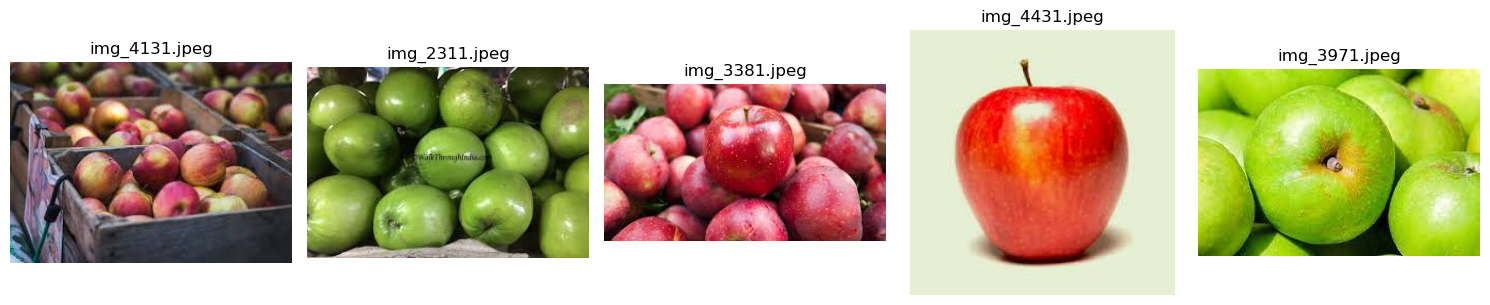

Sample images of class:  avocado


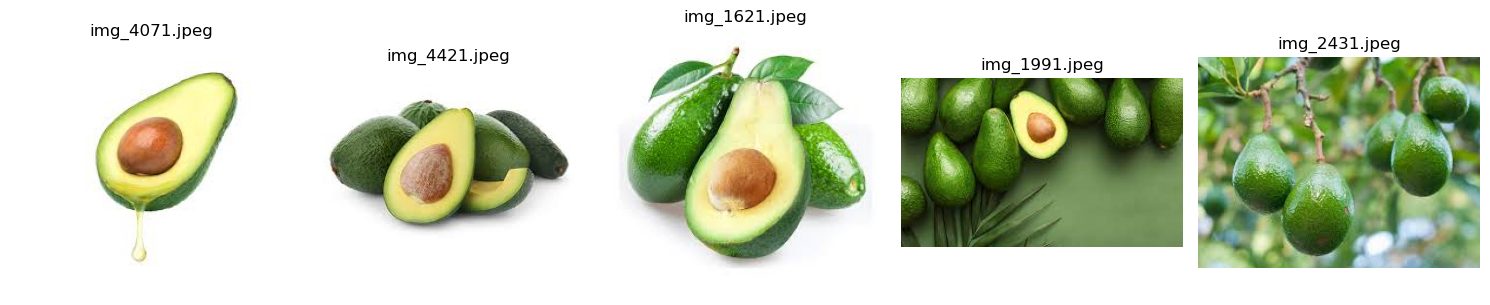

Sample images of class:  Banana


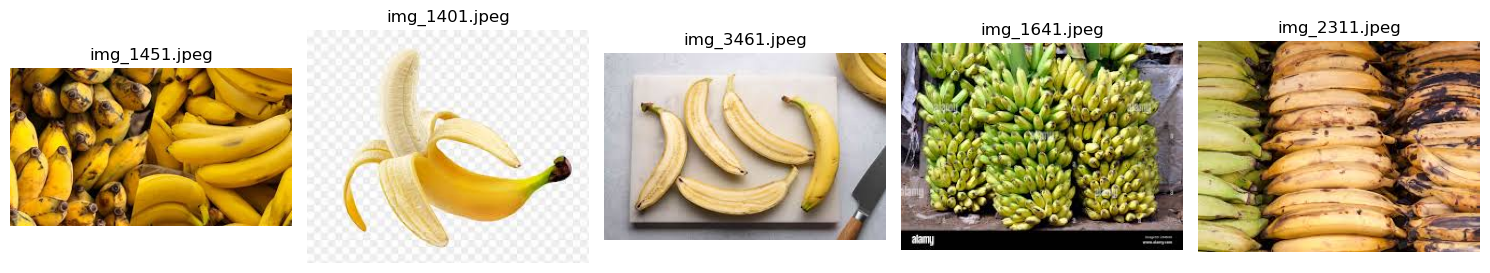

Sample images of class:  cherry


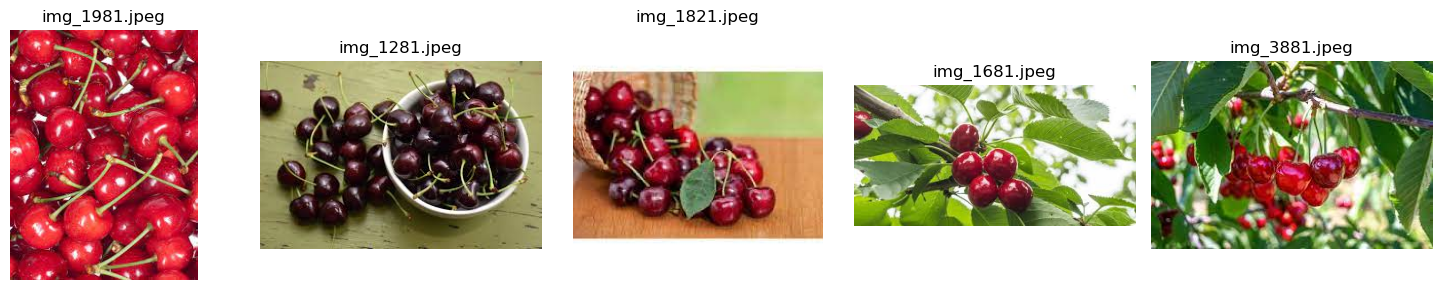

Sample images of class:  kiwi


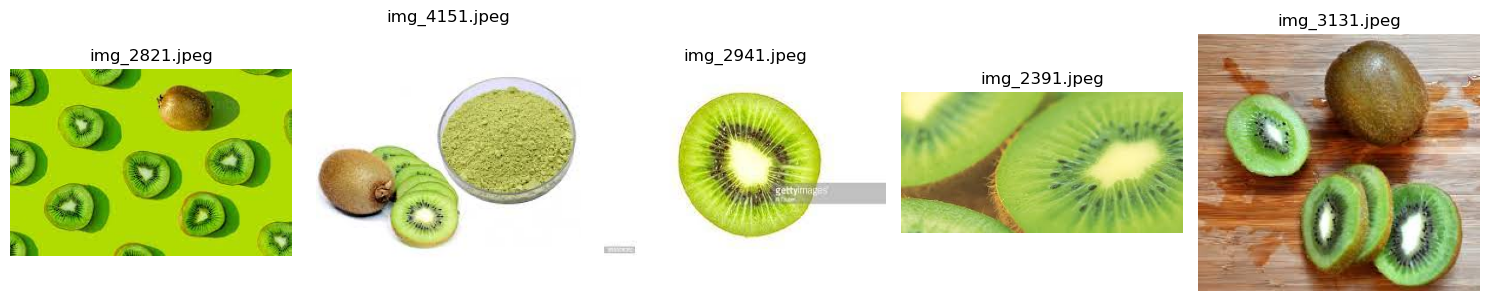

Sample images of class:  mango


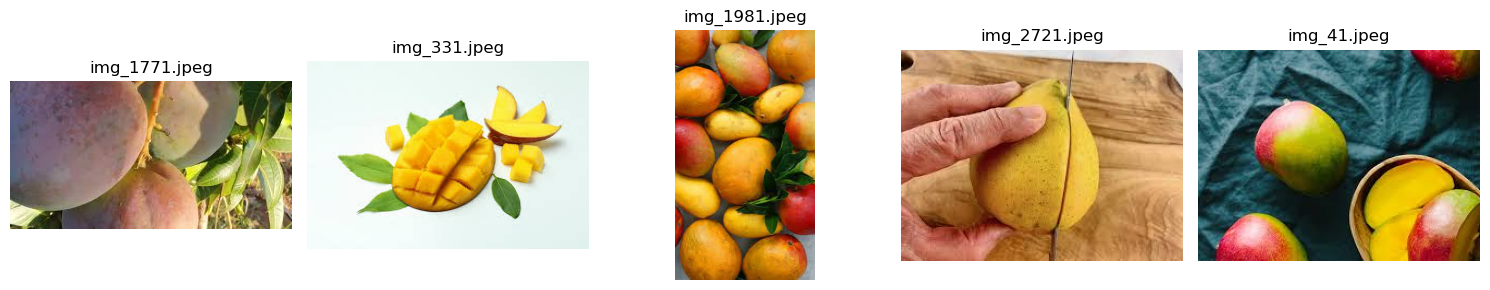

Sample images of class:  orange


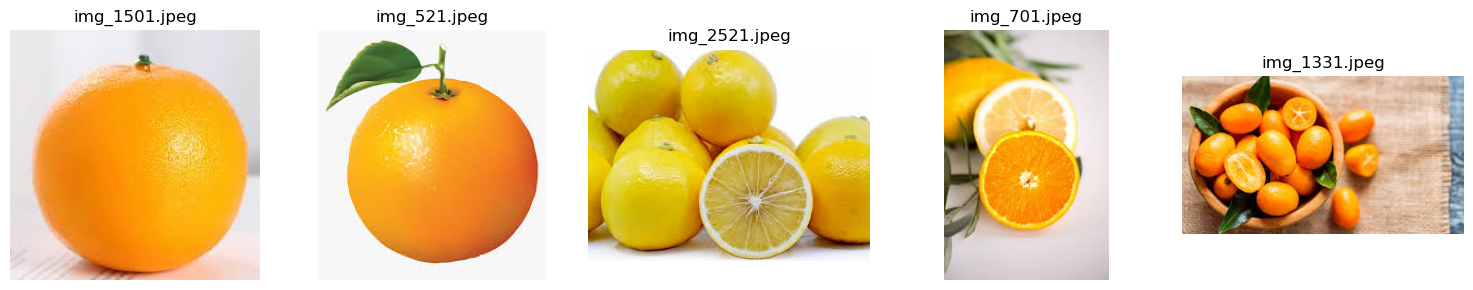

Sample images of class:  pineapple


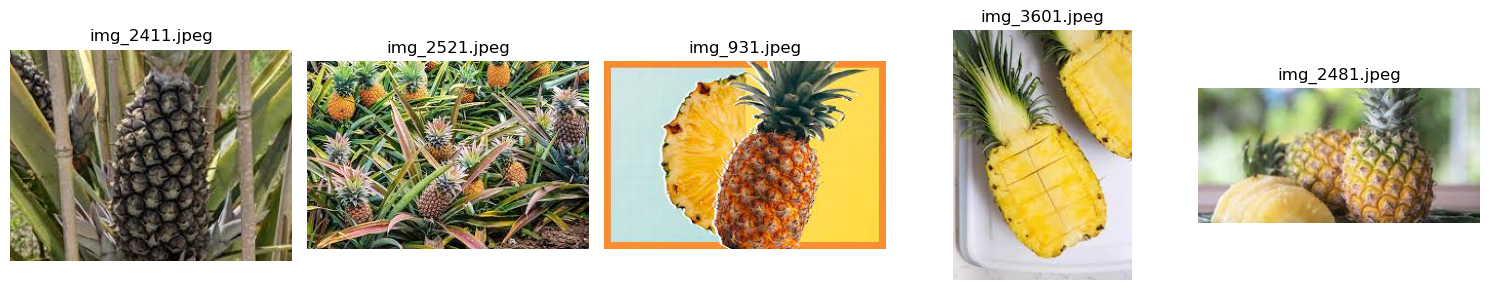

Sample images of class:  strawberries


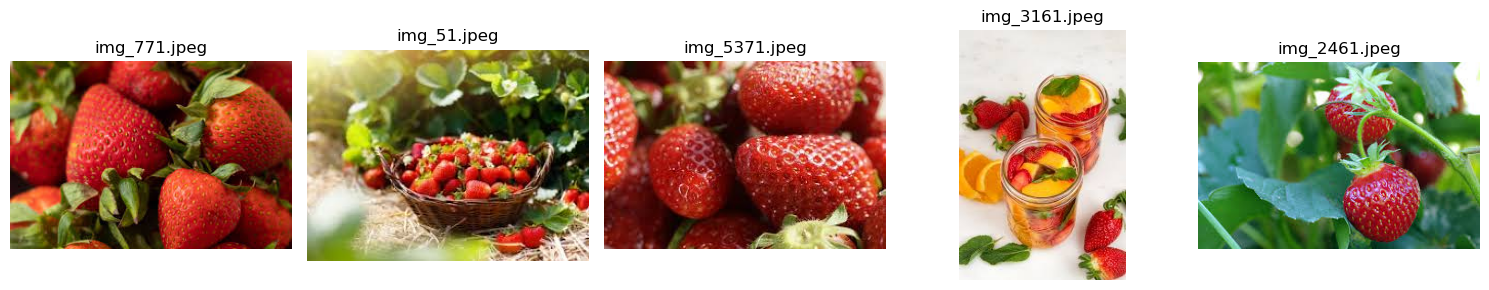

Sample images of class:  watermelon


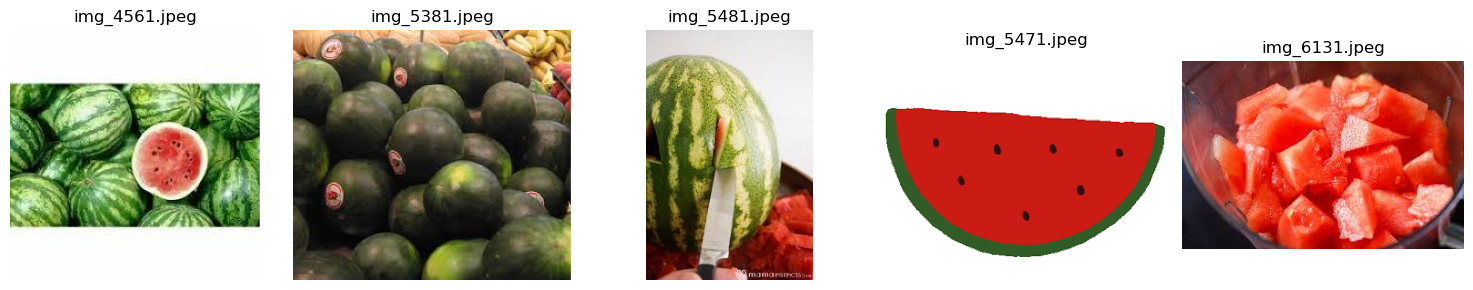

In [43]:
for f in fruits:
    path = os.path.join(base_path, f)
    print('Sample images of class: ', f)
    # Visualize 5 random images
    visualize_images(path, num_images=5)

In [44]:
# Load the pre-trained EfficientNetB4 model without the top classification layer
MobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),
                              pooling='avg')

# Freeze the pre-trained base model layers
MobileNetV2_base.trainable = False

In [45]:
# Build the model
model = Sequential()

# Add the pre-trained Xception base
model.add(MobileNetV2_base)

# Batch Normalization
model.add(BatchNormalization())

# Flattening Layer
model.add(Flatten())

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(256, activation='relu')) 

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(128, activation='relu'))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(64, activation='relu'))

# Add a dense layer with 120 units and ReLU activation function
model.add(Dense(32, activation='relu'))

# Add the output layer with 1 unit and sigmoid activation function for binary classification
model.add(Dense(10, activation='softmax'))

In [46]:
# Check summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 batch_normalization_1 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)               

In [47]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [48]:
%%time
# # Define the callback function
early_stopping = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the path where you want to save the best model
checkpoint_path = 'best_fruit_model.h5'

# Define model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,       # Path to save the model
    monitor='val_accuracy',         # Metric to monitor, e.g., validation loss or accuracy
    save_best_only=True,            # Save only the best model
    mode='max',                     # Mode of the monitored metric, e.g., 'min' for validation loss
    verbose=1                       # Verbosity mode
)

history= model.fit(train_ds,
                   validation_data=validation_ds,
                   epochs=50,
                   callbacks=[early_stopping, checkpoint_callback]
                  )

Epoch 1/50


2024-04-18 10:05:43.120226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - ETA: 0s - loss: 0.8822 - accuracy: 0.7275

2024-04-18 10:06:19.334934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_fruit_model.h5
72/72 [==============================] - 48s 625ms/step - loss: 0.8822 - accuracy: 0.7275 - val_loss: 1.5518 - val_accuracy: 0.6000
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.9009
Epoch 2: val_accuracy improved from 0.60000 to 0.68195, saving model to best_fruit_model.h5
72/72 [==============================] - 44s 615ms/step - loss: 0.2981 - accuracy: 0.9009 - val_loss: 1.4840 - val_accuracy: 0.6820
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.9322
Epoch 3: val_accuracy improved from 0.68195 to 0.69756, saving model to best_fruit_model.h5
72/72 [==============================] - 45s 624ms/step - loss: 0.2097 - accuracy: 0.9322 - val_loss: 1.9098 - val_accuracy: 0.6976
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9435
Epoch 4: val_accuracy did not improve from 0.697

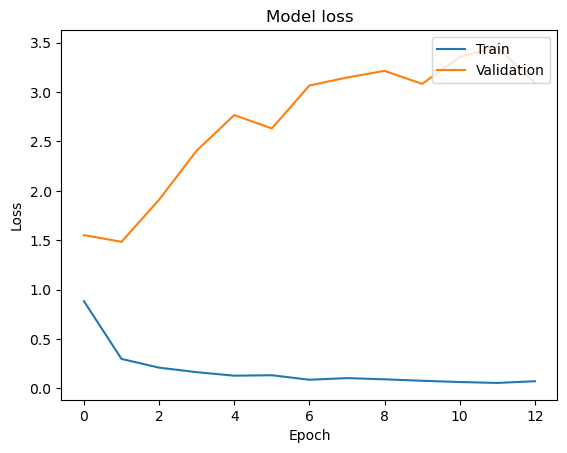

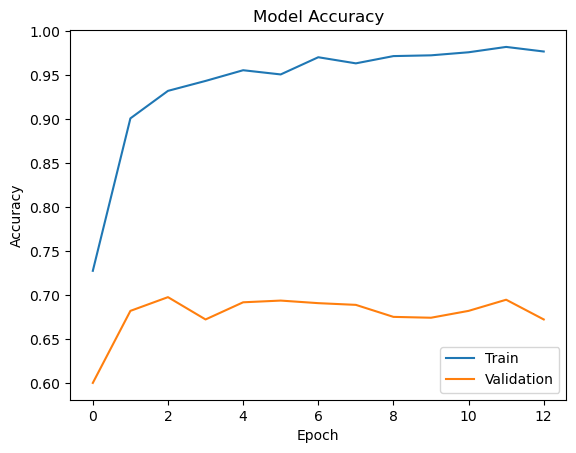

In [49]:
# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

1/1 [==============================] - 0s 339ms/step


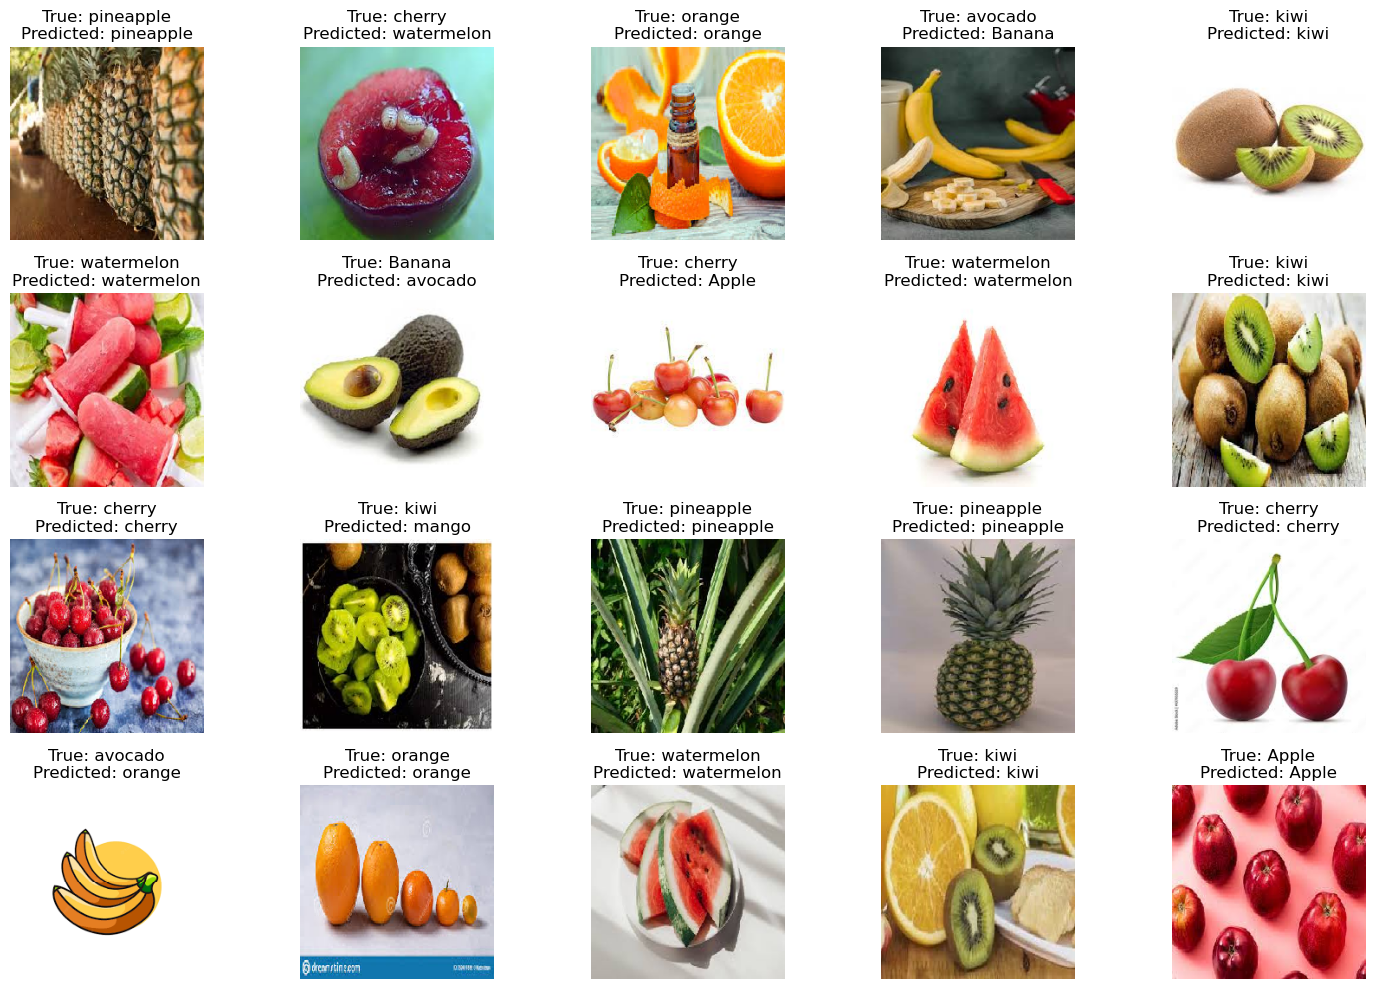

In [50]:
# Get the class labels
class_labels = list(train_ds.class_indices.keys())

# Predict on each image and plot results
num_images = 20
num_images_per_row = 5  # Set the number of images per row
num_rows = 4

plt.figure(figsize=(15, 10))
for i in range(num_images):
    image, label = next(validation_ds)
    predictions = model.predict(image)
    
    # Iterate over each image in the batch
    for j in range(len(image)):
        if i * len(image) + j < num_images:  # Check if the total number of images exceeds the desired count
            predicted_class = class_labels[np.argmax(predictions[j])]
            true_class = class_labels[np.argmax(label[j])]
            
            plt.subplot(num_rows, num_images_per_row, i * len(image) + j + 1)
            plt.imshow(image[j])
            plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
            plt.axis('off')

plt.tight_layout()
plt.show()